In [1]:
import os
import os.path as osp
import sys
import numpy as np
from pprint import pprint

# add matplotlib before cv2, otherwise bug
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0)

# add  
sys.path.insert(0, '../tools')
import _init_paths
from roi_data_layer.layer import RoIDataLayer
from datasets.factory import get_imdb
from model.train_val import get_training_roidb
from layer_utils.proposal_target_layer import proposal_target_layer
from utils.mask_utils import recover_masks
from model.config import cfg
cfg.TRAIN.BATCH_SIZE = 12
cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED = True

# torch
import torch
from torch.autograd import Variable

In [2]:
def vis(imdb, blobs, boxes, masks):
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    im_data = blobs['data'][0].copy()
    im_data += PIXEL_MEANS
    im_data[:,:,:] = im_data[:,:,[2,1,0]]
    im_data = im_data.astype(np.uint8)
    plt.imshow(im_data)
    ax = plt.gca()
    num_objs = boxes.shape[0]
    for ix in range(num_objs):
        # add mask
        m = masks[ix] # uint8
        color_mask = np.random.random((1,3)).tolist()[0]
        img = np.ones( (m.shape[0], m.shape[1], 3) )
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack( (img, m/255.*0.5) ))
        # add box and label
        box = boxes[ix] # float32 (x1y1x2y2,cls)
        x1 = int(round(box[0]))
        y1 = int(round(box[1]))
        x2  = int(round(box[2]))
        y2  = int(round(box[3]))
        cls_ix = int(box[4])
        display_txt = imdb.classes[cls_ix]
        coords = (x1, y1), x2-x1+1, y2-y1+1
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='red', linewidth=2))
        ax.text(x1, y1, display_txt, bbox={'facecolor':'red', 'alpha':0.5})

In [3]:
# dataset
imdb = get_imdb('coco_2014_minival')
imdb.set_proposal_method('gt')
roidb = get_training_roidb(imdb)
# Layer
data_layer = RoIDataLayer(roidb, imdb.num_classes)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Appending horizontally-flipped training examples...
coco_2014_minival gt roidb loaded from /playpen10/licheng/Documents/refer_cvpr2018/mask-faster-rcnn/data/cache/coco_2014_minival_gt_roidb.pkl
done
Preparing training data...
done


In [9]:
# get one batch
blobs = data_layer.forward()
print(blobs.keys())
print(blobs['gt_boxes'].shape)

['gt_boxes', 'data', 'im_info', 'gt_masks']
(9, 5)


In [10]:
# Fake some inputs
num_rpn_rois = min(3, blobs['gt_boxes'].shape[0])
rpn_rois = np.hstack([np.zeros((num_rpn_rois, 1)),
                      blobs['gt_boxes'][:num_rpn_rois, :4]]).astype(np.float32) # float (N, 5) [0xyxy]
rpn_rois = np.vstack([rpn_rois, 
                      np.hstack([np.zeros((num_rpn_rois, 1)), rpn_rois[:, 1:]+100.0])]).astype(np.float32)

gt_boxes = blobs['gt_boxes']   # (M, 5) [xyxycls]
gt_masks = blobs['gt_masks']   # uint8 [0, 1]

In [11]:
# move to gpu Variable
rpn_rois = Variable(torch.from_numpy(rpn_rois).cuda())
gt_boxes = Variable(torch.from_numpy(gt_boxes).float().cuda())
rpn_scores = Variable(torch.randn(gt_boxes.size(0)).cuda())

In [12]:
rois, roi_scores, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights, mask_targets = \
    proposal_target_layer(rpn_rois, rpn_scores, gt_boxes, gt_masks, imdb.num_classes)

In [13]:
imh, imw = int(blobs['im_info'][0][0]), int(blobs['im_info'][0][1])
num_pos = mask_targets.size(0)
boxes = torch.cat([rois[:, 1:5], labels.view(-1,1)], 1).data.cpu().numpy()
boxes = boxes[:num_pos]
masks = recover_masks(mask_targets.data.cpu().numpy(), boxes, imh, imw, 'bilinear')

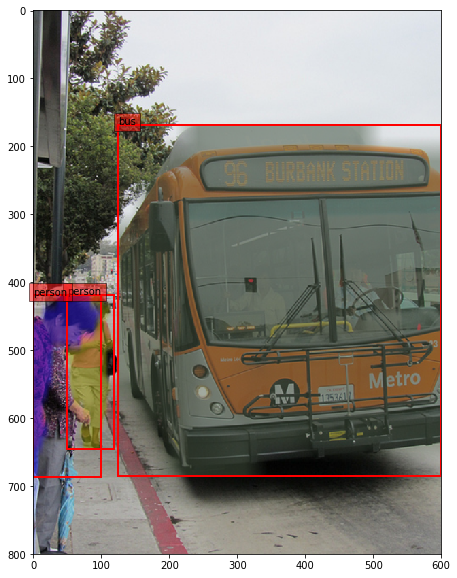

In [14]:
vis(imdb, blobs, boxes, masks)